# **Laboratorio #1: Image demosaicking**

Demosaicing (o de-mosaicing, demosaicking), también conocido como reconstrucción de color, es un algoritmo de procesamiento de imágenes digitales que se utiliza para reconstruir una imagen a todo color a partir de muestras de color incompletas generadas por un sensor de imagen superpuesto con una matriz de filtros de color (CFA), como un filtro Bayer. También se conoce como interpolación CFA o debayering.

La mayoría de las cámaras digitales modernas adquieren imágenes utilizando un único sensor de imagen superpuesto con un CFA, por lo que la demostración es parte del proceso de procesamiento necesario para representar estas imágenes en un formato visible.

Muchas cámaras digitales modernas pueden guardar imágenes en formato RAW (sin formato), lo que permite al usuario realizar una demostración mediante software, en lugar de utilizar el firmware integrado de la cámara.

# Objetivo:
El objetivo de un algoritmo de demosaicking es reconstruir una imagen a todo color (es decir, un conjunto completo de tripletas de color) a partir de los canales de color espacialmente submuestreados emitidos por el CFA. El algoritmo debe tener las siguientes características:



*   Evitar la introducción de artefactos de color falso, como alias cromáticos, cremalleras (cambios bruscos y antinaturales de intensidad en varios píxeles vecinos) y franjas moradas
*   Máxima preservación de la resolución de la imagen
*   Baja complejidad computacional para un procesamiento rápido o una implementación eficiente del hardware en la cámara
*   Facilidad de análisis para una reducción precisa del ruido

![Demosaicking](../resources/images/demosaicking/demosaick.png)

# Imágenes RAW

Existen diferentes formatos de imágenes tipo .RAW:

![RAW Image Formats](../resources/images/demosaicking/RAW_formats.png)




# Montamos la imagen


Vamos a usar una libreria especial para leer imágenes RAW


In [5]:
!pip install rawpy
!pip install scipy
!pip install matplotlib
!pip install opencv-python

Importemos los paquetes necesarios para realizar el procesamiento

In [6]:
import rawpy
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy.signal import convolve2d

Leamos y mostremos una de las imágenes RAW disponibles en nuestra carpeta

Leyendo imagen .RAW ...
Tamaño de la imagen: (2622, 3948)


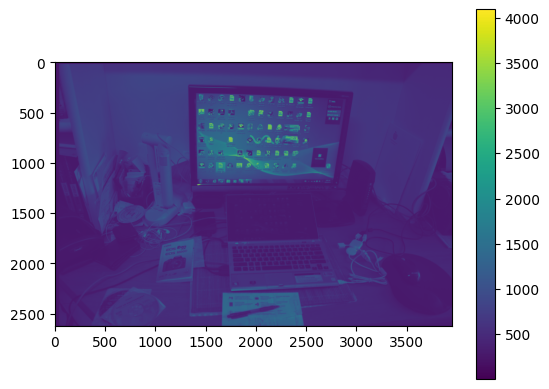

In [7]:
# Load RAW file
with rawpy.imread('../resources/images/demosaicking/scene_raw.CR2') as raw:
    print('Leyendo imagen .RAW ...')
    image = raw.raw_image.copy()

print(f'Tamaño de la imagen: {image.shape}')
plt.imshow(image)
plt.colorbar()
plt.show()

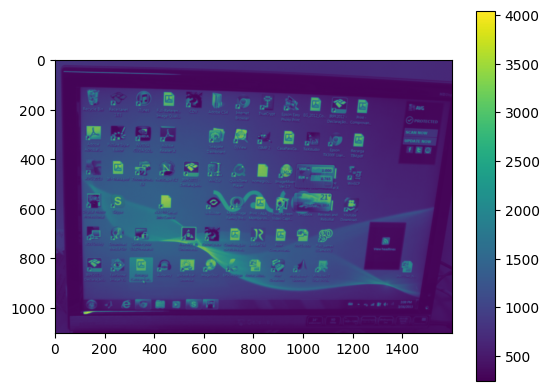

In [8]:
# Enfocandonos en una región particular
plt.imshow(image[200:1300, 1300:2900])
plt.colorbar()
plt.show()

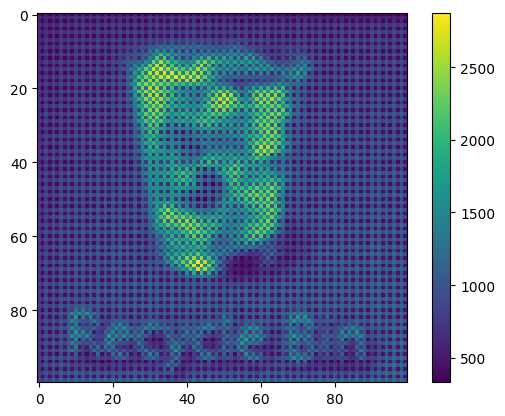

In [9]:
# Hagamos Zoom para ver el patrón Bayer
plt.imshow(image[310:410, 1405:1505])
plt.colorbar()
plt.show()

# **Let's do Demosaicking**

Comenzaremos separando el canal único en tres canales de colores diferentes: rojo, verde y azul (RGB).

In [10]:
RED = 0
GREEN = 1
BLUE = 2
def get_cfa_channel(i, j):
    # CR2 CFA Pattern: [Red   , Green] <-- even rows: 0, 2, 4, ...
    #                  [Green , Blue]  <-- odd  rows: 1, 3, 5, ...
    if i%2 == 0:
      if j%2 == 0:
        return RED
      else:
        return GREEN
    else:
      if j%2 == 0:
        return GREEN
      else:
        return BLUE

In [11]:
get_cfa_channel(1,1)

2

In [12]:
def get_cfa_mask(shape):
    mask = np.zeros(shape)
    for i in range(shape[0]):
      for j in range(shape[1]):
        mask[i,j] = get_cfa_channel(i,j)

    return mask

In [13]:
cfa_mask = get_cfa_mask(image.shape)

In [14]:
cfa_mask.shape

(2622, 3948)

In [15]:
cfa_mask.dtype

dtype('float64')

In [16]:
print(cfa_mask)

[[0. 1. 0. ... 1. 0. 1.]
 [1. 2. 1. ... 2. 1. 2.]
 [0. 1. 0. ... 1. 0. 1.]
 ...
 [1. 2. 1. ... 2. 1. 2.]
 [0. 1. 0. ... 1. 0. 1.]
 [1. 2. 1. ... 2. 1. 2.]]


Comenzando proceso de Demosaicking:
Extrayendo filtros respecto a su posición...
Separando los diferentes canales de color...


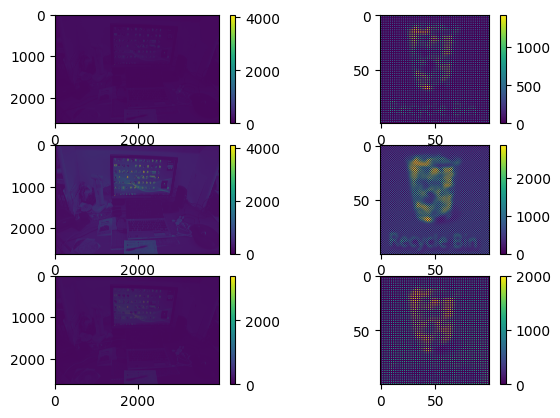

In [17]:
print('Comenzando proceso de Demosaicking:')
print('Extrayendo filtros respecto a su posición...')
r_mask = (cfa_mask == RED)
g_mask = (cfa_mask == GREEN)
b_mask = (cfa_mask == BLUE)

print('Separando los diferentes canales de color...')
r = image * r_mask
g = image * g_mask
b = image * b_mask

plt.subplot(3,2,1)
plt.imshow(r)
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(r[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,3)
plt.imshow(g)
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(g[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,5)
plt.imshow(b)
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(b[310:410, 1405:1505])
plt.colorbar()
#plt.show()

# Llenando huecos

Completemos los valores faltantes usando interpolación lineal. Este es un enfoque muy básico.

![Bilinear interpolation](../resources/images/demosaicking/Bilinear_interpolation.png)

Ejecutando interpolación lineal utilizando "convolución"


/tmp/ipykernel_11918/4172242070.py:14: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  r = filters.convolve(r, RB_KERNEL)
/tmp/ipykernel_11918/4172242070.py:15: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  g = filters.convolve(g, G_KERNEL)
/tmp/ipykernel_11918/4172242070.py:16: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  b = filters.convolve(b, RB_KERNEL)


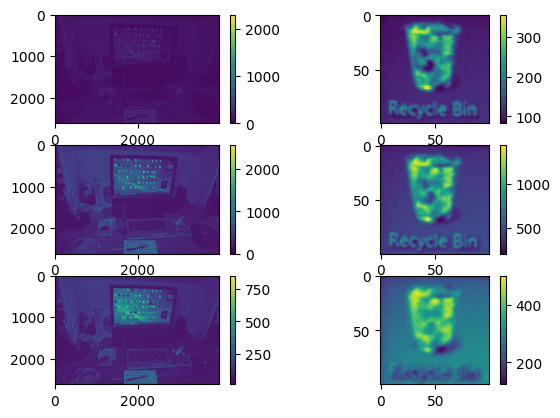

In [18]:
#Filtro lineal para el canal verde
G_KERNEL = np.asarray(
    ((0.0, 1.0, 0.0),
     (1.0, 4.0, 1.0),
     (0.0, 1.0, 0.0))) / 8

#Filtro lineal para los canales azul y rojo (Note la diferencia)
RB_KERNEL = np.asarray(
    ((1.0, 2.0, 1.0),
     (2.0, 4.0, 2.0),
     (1.0, 2.0, 1.0))) / 16

print('Ejecutando interpolación lineal utilizando "convolución"')
r = filters.convolve(r, RB_KERNEL)
g = filters.convolve(g, G_KERNEL)
b = filters.convolve(b, RB_KERNEL)

plt.subplot(3,2,1)
plt.imshow(r)
plt.colorbar()
plt.subplot(3,2,2)
plt.imshow(r[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,3)
plt.imshow(g)
plt.colorbar()
plt.subplot(3,2,4)
plt.imshow(g[310:410, 1405:1505])
plt.colorbar()
#plt.show()

plt.subplot(3,2,5)
plt.imshow(b)
plt.colorbar()
plt.subplot(3,2,6)
plt.imshow(b[310:410, 1405:1505])
plt.colorbar()
#plt.show()

Agrupemos estos tres canales en una sola imagen.


Agrupando canales para generar imagen RGB ...


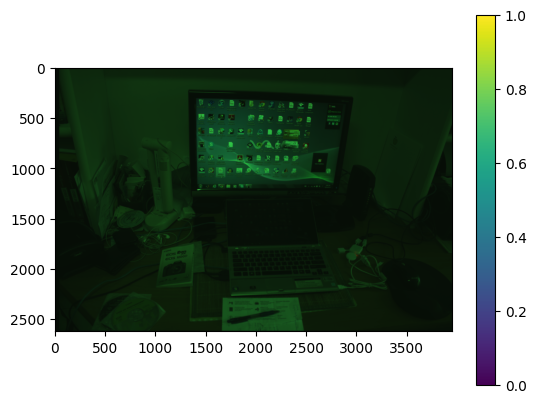

In [19]:
print('Agrupando canales para generar imagen RGB ...')
rgb = np.dstack((r, g, b))
plt.imshow(rgb / rgb.max()) # Normalización
plt.colorbar()
plt.show()

# **Correcciones de color**
La imagen todavía no se ve como esperábamos. Esto se debe a que nos faltan dos pasos cruciales: la resta del nivel de negro y el balanceo de blancos.

Ajustando el nivel de negro ...
Balanceando blancos ...


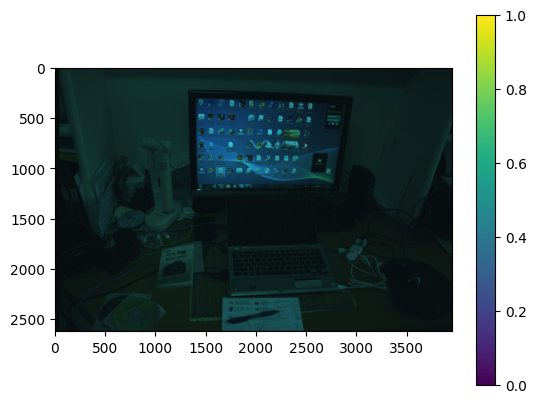

In [20]:
print('Ajustando el nivel de negro ...')
rgb -= np.array((r.min(), g.min(), b.min()))

print('Balanceando blancos ...')
rgb = rgb / np.array((r.max() - r.min(), g.max() - g.min(), b.max() - b.min()))

plt.imshow(rgb)
plt.colorbar()
plt.show()

Nuevamente, este es un enfoque muy básico, ya que no utilizamos ninguna de las estadísticas del fabricante de la cámara ni la sensibilidad configurada con la que se capturó la imagen.

Terminaremos con una corrección gamma (pronto la veremos) para enriquecer los colores.

Aplicando corrección Gamma...


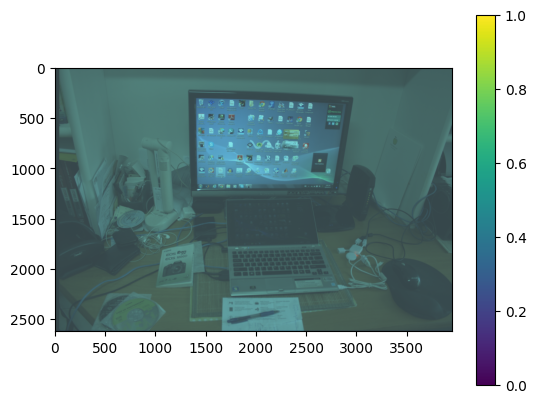

In [21]:
GAMMA = 1 / 2.3

print('Aplicando corrección Gamma...')
rgb = rgb ** GAMMA

plt.imshow(rgb)
plt.colorbar()
plt.show()

In [22]:
import PIL

In [23]:
rgb = PIL.Image.fromarray(rgb.astype(np.uint8))
rgb.save('../resources/images/demosaicking/image_save.jpg')

Carguemos la imagen .RAW nuevamente y ejecutemos un método avanzado (por defecto en el paquete `rawpy`).
¿Puedes notar la diferencia?

Reading image raw data...


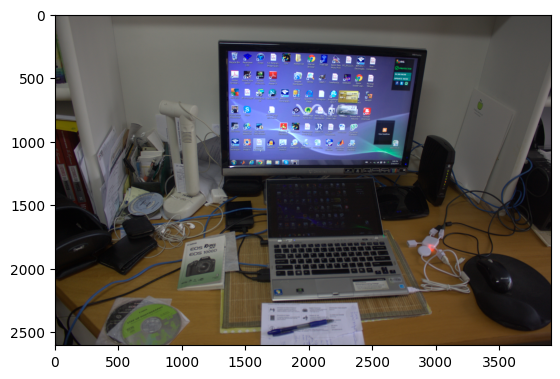

In [24]:
# Comparando contra la imagen original
with rawpy.imread('../resources/images/demosaicking/scene_raw.CR2') as raw:
    print('Reading image raw data...')
    rgb2 = raw.postprocess(use_camera_wb=True)

plt.imshow(rgb2)

In [25]:
print(rgb2.dtype)

uint8


Exportemos la imagen para poder comparar en el futuro

In [26]:
PIL.Image.fromarray(rgb2).save('../resources/images/demosaicking/imagenRGB_original.jpg')

# **Taller**

1. Realizar el proceso de demosaicking a por lo menos 2 imágenes RAW:

*   Por medio de interpolación lineal.
*   Por medio de interpolación cúbica.
*   Algún otro método avanzado (investigar!)

2. Inspeccionar visualmente la calidad espacial de ambas imágenes y describir sus observaciones.

3. Medir el error cuadrático medio (RMSE) y el error absoluto medio (MAE) entre las imágenes RGB de referencia y las estimadas con demosaicking.

4. Generar el mapa de diferencias de píxeles para visualizar dónde se cometen los errores

# Solución taller - Proceso de demosaicking

## P0 - Importamos las imágenes para trabajar

Seleccionamos las siguientes imágenes RAW para el proceso de demosaicking.

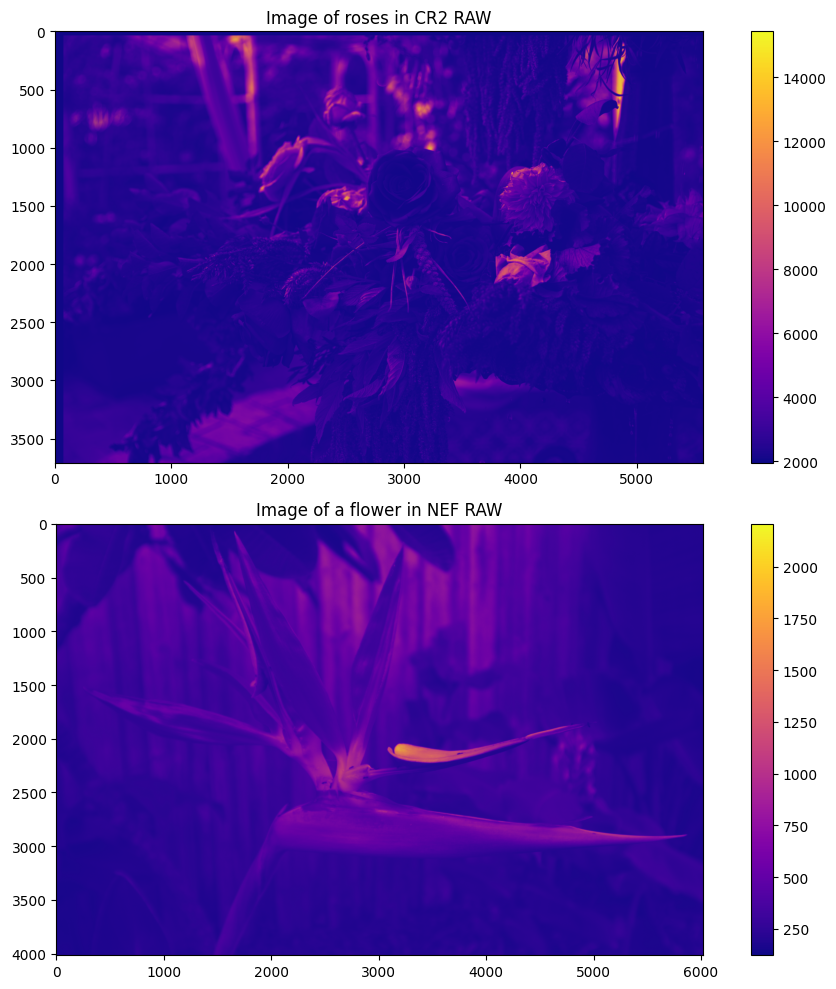

In [27]:
with rawpy.imread('../resources/images/demosaicking/scene_raw_Canon.CR2') as raw1:
    roses_raw = raw1.raw_image.copy()

with rawpy.imread('../resources/images/demosaicking/scene_raw_Nikon.NEF') as raw2:
    flower_raw = raw2.raw_image.copy()

images_colors = 'plasma'

plt.figure(figsize=(10, 10))
plt.subplot(2, 1 ,1)
plt.imshow(roses_raw, cmap = images_colors)
plt.colorbar()
plt.title('Image of roses in CR2 RAW')
plt.subplot(2, 1, 2)
plt.imshow(flower_raw, cmap = images_colors)
plt.colorbar()
plt.title('Image of a flower in NEF RAW')
plt.tight_layout()
plt.show()

Separamos los canales para cada una de las imágenes.

In [28]:
def separate_channels(raw_image):
    cfa_bayer = get_cfa_mask(raw_image.shape)
    r_pos = (cfa_bayer == RED)
    g_pos = (cfa_bayer == GREEN)
    b_pos = (cfa_bayer == BLUE)
    r = raw_image * r_pos
    g = raw_image * g_pos
    b = raw_image * b_pos
    return np.array([r, g, b])

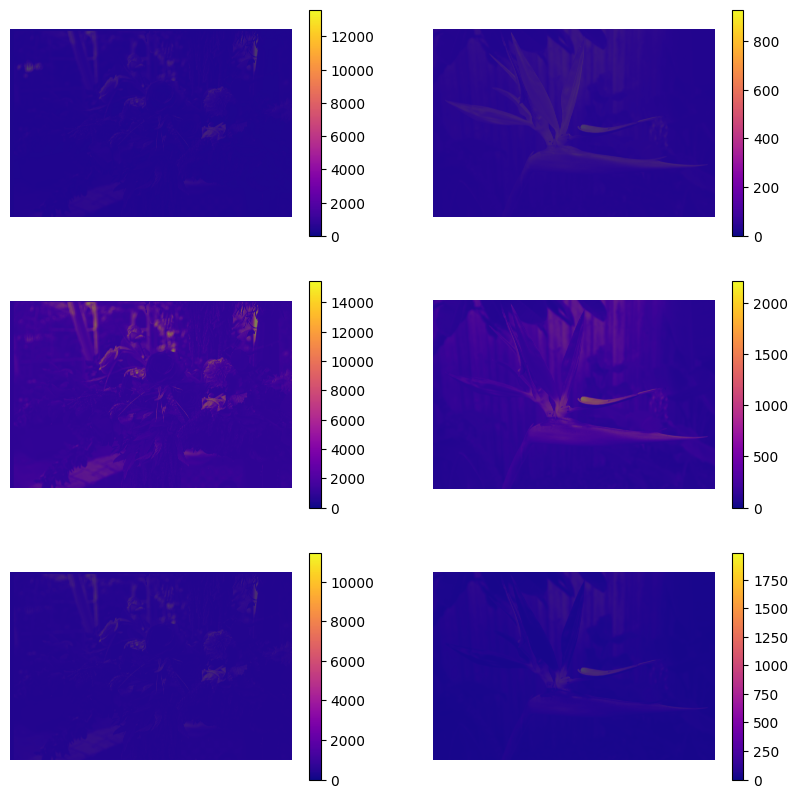

In [29]:
roses_channels = separate_channels(roses_raw)
flower_channels = separate_channels(flower_raw)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(roses_channels[0], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(roses_channels[1], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(roses_channels[2], cmap = images_colors)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(flower_channels[0], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(flower_channels[1], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(flower_channels[2], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.show()

Hacemos un acercamiento a una región para observar el patrón Bayer.

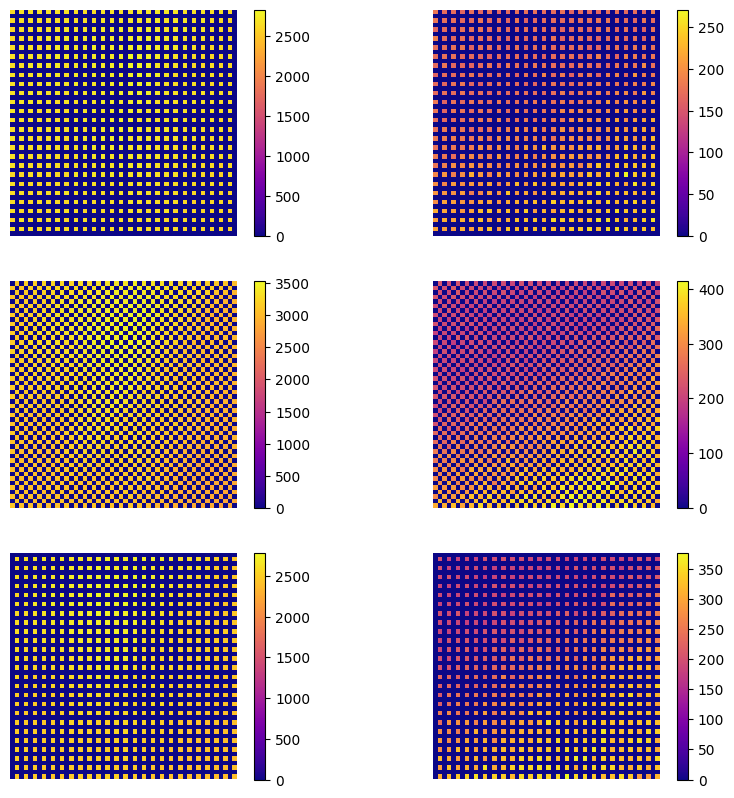

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(roses_channels[0][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(roses_channels[1][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(roses_channels[2][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(flower_channels[0][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(flower_channels[1][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(flower_channels[2][100:150, 100:150], cmap = images_colors)
plt.axis('off')
plt.colorbar()
plt.show()

## P1 - Implementamos algoritmos de demosaicking

Implementamos el algoritmo de interpolación lineal.

In [31]:
def linear_interpolation(r_channel, g_channel, b_channel):
    #Filtro lineal para el canal verde.
    G_KERNEL = np.asarray(
        ((0.0, 1.0, 0.0),
         (1.0, 4.0, 1.0),
         (0.0, 1.0, 0.0))) / 8
    
    #Filtro lineal para los canales azul y rojo.
    RB_KERNEL = np.asarray(
        ((1.0, 2.0, 1.0),
         (2.0, 4.0, 2.0),
         (1.0, 2.0, 1.0))) / 16
    
    r_full = ndimage.convolve(r_channel, RB_KERNEL)
    g_full = ndimage.convolve(g_channel, G_KERNEL)
    b_full = ndimage.convolve(b_channel, RB_KERNEL)

    image_result = np.dstack((r_full, g_full, b_full))
    return image_result / image_result.max()

Implementamos el algoritmos de interpolación cúbica.

In [32]:
def cubic_interpolation(r_channel, g_channel, b_channel):
    g_kernel = np.asarray(
        ((0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0),
         (0.0, 0.0, -9.0, 0.0, -9.0, 0.0, 0.0),
         (0.0, -9.0, 0.0, 81.0, 0.0, -9.0, 0.0),
         (1.0, 0.0, 81.0, 256.0, 81.0, 0.0, 1.0),
         (0.0, -9.0, 0.0, 81.0, 0.0, -9.0, 0.0),
         (0.0, 0.0, -9.0, 0.0, -9.0, 0.0, 0.0),
         (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
        ) / 256
    
    rb_kernel = np.asarray(
        ((1, 0, -9, -16, -9, 0, 1),
         (0, 0, 0, 0, 0, 0, 0),
         (-9, 0, 81, 144, 81, 0, -9),
         (-16, 0, 144, 256, 144, 0, -16),
         (-9, 0, 81, 144, 81, 0, -9),
         (0, 0, 0, 0, 0, 0, 0),
         (1, 0, -9, -16, -9, 0, 1))
        ) / 256

    r_full = ndimage.convolve(r_channel, rb_kernel)
    g_full = ndimage.convolve(g_channel, g_kernel)
    b_full = ndimage.convolve(b_channel, rb_kernel)

    image_result = np.dstack((r_full, g_full, b_full))
    return image_result / image_result.max()

Implementamos el algoritmo de Malvar.

In [33]:
def malvar_method(raw_image):

    red_kernel = np.array([[0, 1, 0],
                           [1, 4, 1],
                           [0, 1, 0]]) / 6.0

    blue_kernel = np.array([[0, 1, 0],
                            [1, 4, 1],
                            [0, 1, 0]]) / 6.0

    green_kernel = np.array([[0, 0, 0],
                             [0, 4, 0],
                             [0, 0, 0]]) / 4.0

    green_mask = np.zeros_like(raw_image, dtype=bool)
    green_mask[::2, 1::2] = True
    green_mask[1::2, ::2] = True
    
    g_full = convolve2d(raw_image * green_mask, green_kernel, mode='same', boundary='symm')
    r_full = convolve2d(raw_image * ~green_mask, red_kernel, mode='same', boundary='symm')
    b_full = convolve2d(raw_image * ~green_mask, blue_kernel, mode='same', boundary='symm')

    image_result = np.dstack((r_full, g_full, b_full))
    return image_result / image_result.max()

Es necesario que apliquemos **correciones de color**, entonces se define la siguiente función para eso.

In [34]:
def black_remainder(r_channel, g_channel, b_channel, image):
    image -= np.array((r_channel.min(), g_channel.min(), b_channel.min()))
    return image

def white_balance(r_channel, g_channel, b_channel, image):
    balance = np.array((r_channel.max() - r_channel.min(), g_channel.max() - g_channel.min(), b_channel.max() - b_channel.min()))
    image = image / balance
    return image

def gamma_correction(image, gamma):
    if gamma == None:
        gamma = 1.0 / 2.3
    return image ** gamma

def color_corrections(image, gamma_value):
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]
    
    corrected = black_remainder(red, green, blue, np.copy(image))
    corrected = white_balance(red, green, blue, corrected)
    corrected = gamma_correction(corrected, gamma_value)
    return corrected

Aplicamos los algoritmos a los canales de las imágenes RAW que se propusieron. Primero a las rosas.

In [35]:
gamma_roses = None

linear_roses = linear_interpolation(roses_channels[0], roses_channels[1], roses_channels[2])
linear_roses = color_corrections(linear_roses, gamma_roses)
cubic_roses = cubic_interpolation(roses_channels[0], roses_channels[1], roses_channels[2])
cubic_roses = color_corrections(cubic_roses, gamma_roses)
malvar_roses = malvar_method(roses_raw)
malvar_roses = color_corrections(malvar_roses, gamma_roses)

In [36]:
gamma_flower = None

linear_flower = linear_interpolation(flower_channels[0], flower_channels[1], flower_channels[2])
linear_flower = color_corrections(linear_flower, gamma_flower)
cubic_flower = cubic_interpolation(flower_channels[0], flower_channels[1], flower_channels[2])
cubic_flower = color_corrections(cubic_flower, gamma_flower)
malvar_flower = malvar_method(flower_raw)
malvar_flower = color_corrections(malvar_flower, gamma_flower)

Visualizamos los resultados.

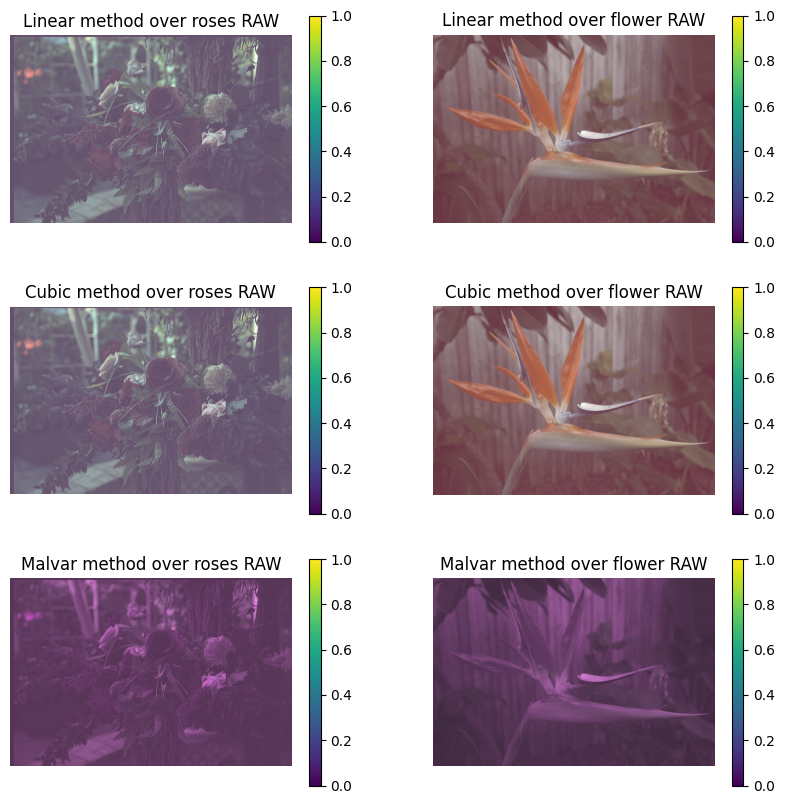

In [35]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(linear_roses)
plt.title('Linear method over roses RAW')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(cubic_roses)
plt.title('Cubic method over roses RAW')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(malvar_roses)
plt.title('Malvar method over roses RAW')
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(linear_flower)
plt.title('Linear method over flower RAW')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(cubic_flower)
plt.title('Cubic method over flower RAW')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(malvar_flower)
plt.title('Malvar method over flower RAW')
plt.axis('off')
plt.colorbar()
plt.show()

## P2 - Inspección y observaciones de las imágenes obtenidas

Seleccionamos áreas de interes para cada una de las imágenes.

## P3 - Cálculo de error entre la referencia y las imágenes reconstruidas

Se hace las definiciones para el cálculo de los tipos de error por canal, es decir, el **raíz del error cuadrático medio (RMSE)** y el **error absoluto medio (MAE)** por cada color de la imagen obtenida versus la imagen de referencia. En este caso la imagen de referencia se obtiene usando `rawpy.postproccess`, que internamente usa el algoritmo de **Demosaico Dirigido por Homogeneidad Adaptativa (Adaptative Homogeneity-Directed Demosaicing Algorithm, AHD)**.

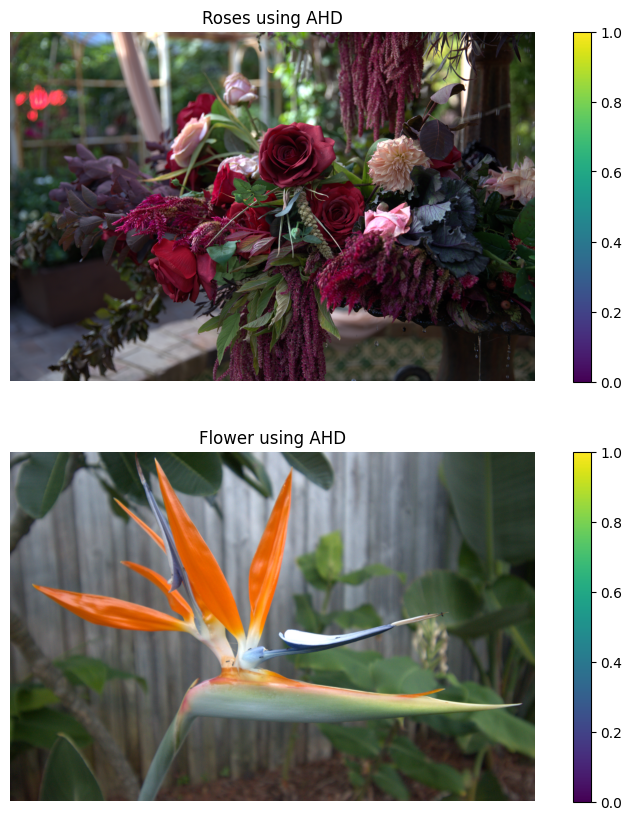

In [37]:
with rawpy.imread('../resources/images/demosaicking/scene_raw_Canon.CR2') as raw_ref_roses:
    roses_ref = raw_ref_roses.postprocess(use_camera_wb = True)

with rawpy.imread('../resources/images/demosaicking/scene_raw_Nikon.NEF') as raw_ref_flower:
    flower_ref = raw_ref_flower.postprocess(use_camera_wb = True)

roses_ref = roses_ref / roses_ref.max()
flower_ref = flower_ref / flower_ref.max()
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(roses_ref)
plt.title('Roses using AHD')
plt.axis('off')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(flower_ref)
plt.title('Flower using AHD')
plt.axis('off')
plt.colorbar()

Se usan las siguientes ecuaciones para los canales vectorizados, en este caso, se hace la descripción para el canal rojo ($r$):

$$
\begin{gather}
RSME = \sqrt{\frac{1}{n} \sum^n_{i = 1} ({r}_{estimated} - {r}_{reference})^2 } \\
MAE = \frac{1}{n} \sum^n_{i = 1} |{r}_{estimated} - {r}_{reference}|
\end{gather}
$$

In [38]:
def rmse_error(estimated_channel, reference_channel):
    squared_err = np.square(estimated_channel - reference_channel)
    mse = np.mean(squared_err)
    rmse = np.sqrt(mse)
    return rmse

def mae_error(estimated_channel, reference_channel):
    abs_err = np.abs(estimated_channel - reference_channel)
    mae = np.mean(abs_err)
    return mae

def channel_errors(estimated_channel, reference_channel):
    return [rmse_error(estimated_channel, reference_channel), mae_error(estimated_channel, reference_channel)]

def image_errors(estimated_img, reference_img):
    red_error = channel_errors(cv2.resize(estimated_img[:, :, 0], reference_img.shape[0:2][::-1]), reference_img[:, :, 0])
    green_error = channel_errors(cv2.resize(estimated_img[:, :, 1], reference_img.shape[0:2][::-1]), reference_img[:, :, 1])
    blue_error = channel_errors(cv2.resize(estimated_img[:, :, 2], reference_img.shape[0:2][::-1]), reference_img[:, :, 2])

    return np.array([red_error, green_error, blue_error])

Hacemos el cálculo para cada método y su imagen estimada, en contra de la imagen de referencia.

In [39]:
linear_roses_errors = image_errors(linear_roses, roses_ref)
cubic_roses_errors = image_errors(cubic_roses, roses_ref)
malvar_roses_errors = image_errors(malvar_roses, roses_ref)

linear_flower_errors = image_errors(linear_flower, flower_ref)
cubic_flower_errors = image_errors(cubic_flower, flower_ref)
malvar_flower_errors = image_errors(malvar_flower, flower_ref)

Definimos una función para poder graficar uniformemente los resultados de los errores.

In [39]:
def error_grapher(error_matrix, method_name, image_name):
    error_names = ["RMSE", "MAE"]
    channel_errors = {
        'Red': error_matrix[0, ],
        'Green': error_matrix[1, ],
        'Blue': error_matrix[2, ],
    }
    
    x = np.arange(len(error_names))
    width = 0.25
    multiplier = 0
    
    colors = [('red', 0.9), ('green', 0.9), ('blue', 0.9)]
    fig, ax = plt.subplots(layout = 'constrained')
    for channel, error in channel_errors.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, error, width, label = channel, color = colors[multiplier])
        ax.bar_label(rects, padding = 3)
        multiplier += 1
    
    ax.set_xlabel('Types of error')
    ax.set_ylabel('Total error')
    ax.set_title(f'{method_name} performance over {image_name}')
    ax.set_xticks(x + width, error_names)
    ax.legend(loc = 'upper left', ncols = 1)
    ax.set_ylim(0, 1)
    plt.show()

Presentamos los resultados.

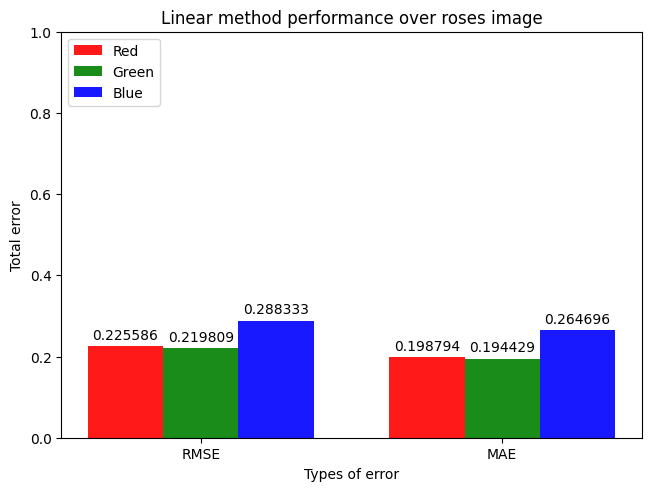

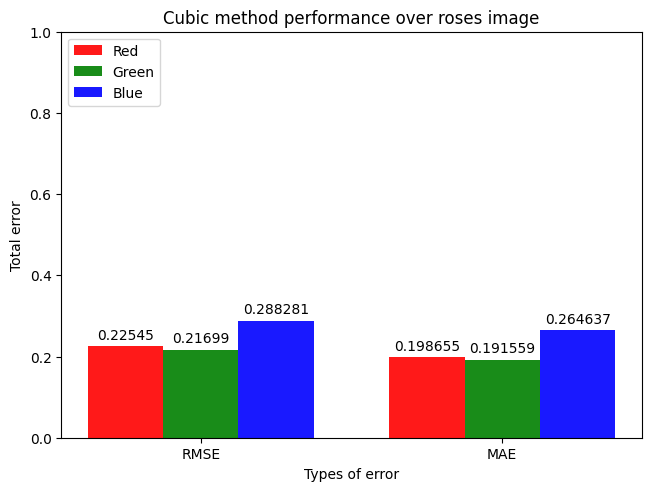

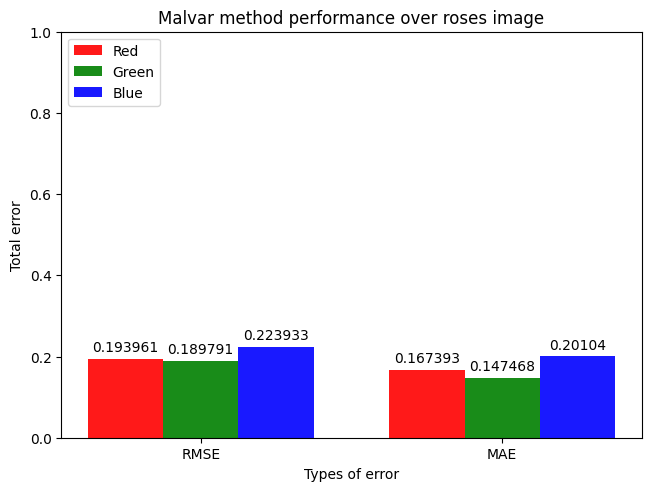

In [40]:
error_grapher(linear_roses_errors, "Linear method", "roses image")
error_grapher(cubic_roses_errors, "Cubic method", "roses image")
error_grapher(malvar_roses_errors, "Malvar method", "roses image")

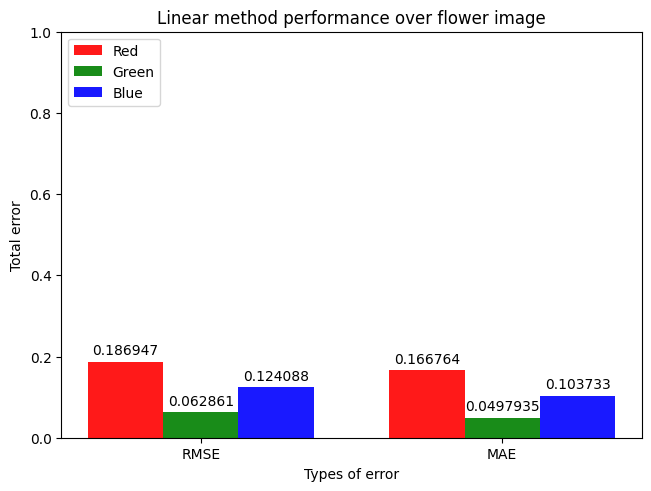

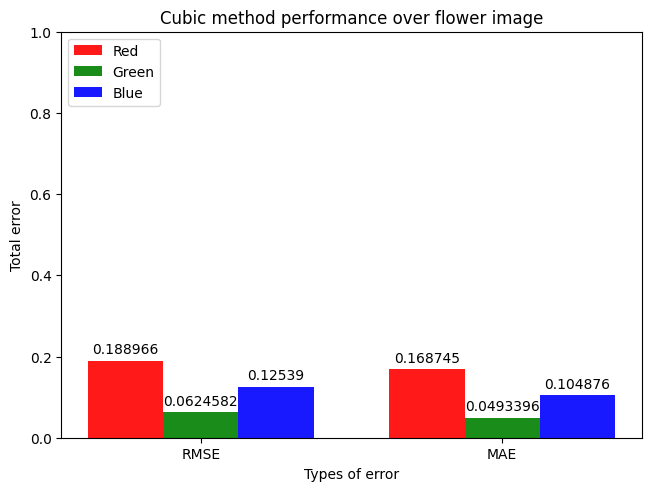

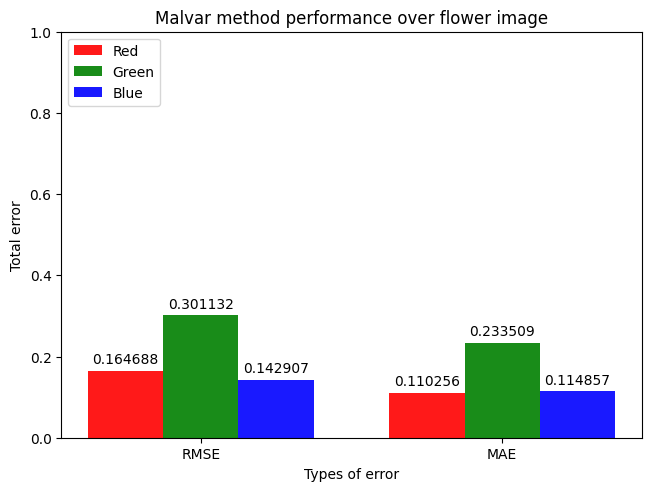

In [41]:
error_grapher(linear_flower_errors, "Linear method", "flower image")
error_grapher(cubic_flower_errors, "Cubic method", "flower image")
error_grapher(malvar_flower_errors, "Malvar method", "flower image")

## P4 - Mapa de diferencias

Representamos las diferencias para cada canal de las imágenes obtenidas.

In [40]:
def difference_map(estimated_img, reference_img):
    diff_red = np.abs(cv2.resize(estimated_img[:, :, 0], reference_img.shape[0:2][::-1]) - reference_img[:, :, 0])
    diff_green = np.abs(cv2.resize(estimated_img[:, :, 1], reference_img.shape[0:2][::-1]) - reference_img[:, :, 1])
    diff_blue = np.abs(cv2.resize(estimated_img[:, :, 2], reference_img.shape[0:2][::-1]) - reference_img[:, :, 2])

    return np.dstack((diff_red, diff_green, diff_blue))

Calculamos los mapas de diferencias.

In [41]:
linear_roses_diffs = difference_map(linear_roses, roses_ref)
cubic_roses_diffs = difference_map(cubic_roses, roses_ref)
malvar_roses_diffs = difference_map(malvar_roses, roses_ref)

linear_flower_diffs = difference_map(linear_flower, flower_ref)
cubic_flower_diffs = difference_map(cubic_flower, flower_ref)
malvar_flower_diffs = difference_map(malvar_flower, flower_ref)

Mapas para la interpolación lineal:

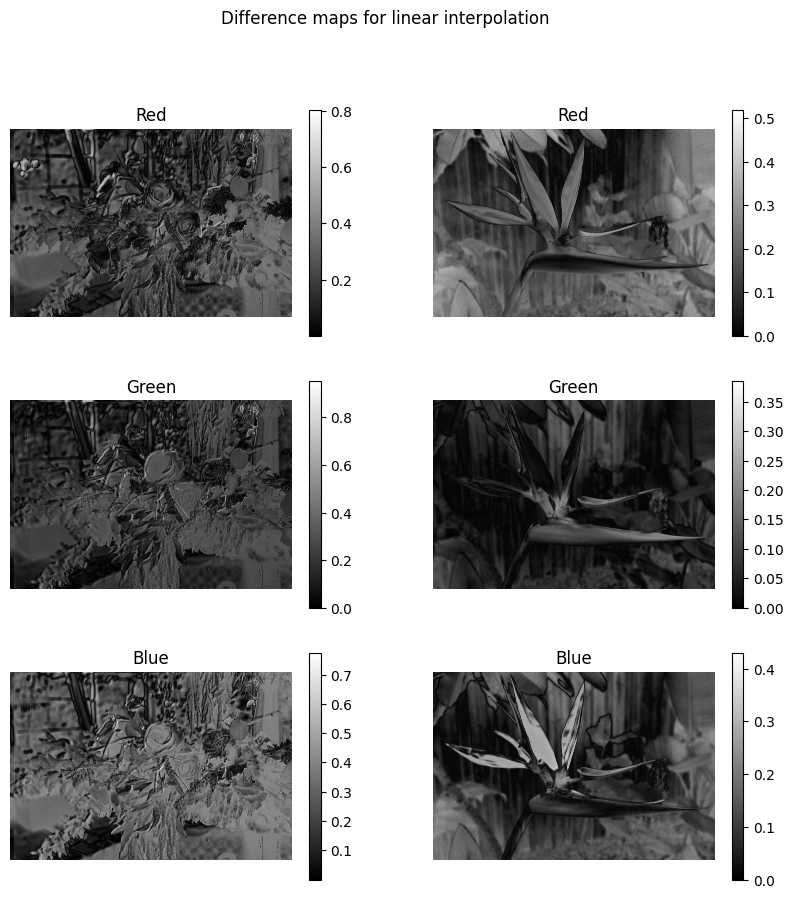

In [42]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(linear_roses_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(linear_roses_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(linear_roses_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(linear_flower_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(linear_flower_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(linear_flower_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()
plt.suptitle('Difference maps for linear interpolation')
plt.show()

Mapas para la interpolación cúbica:

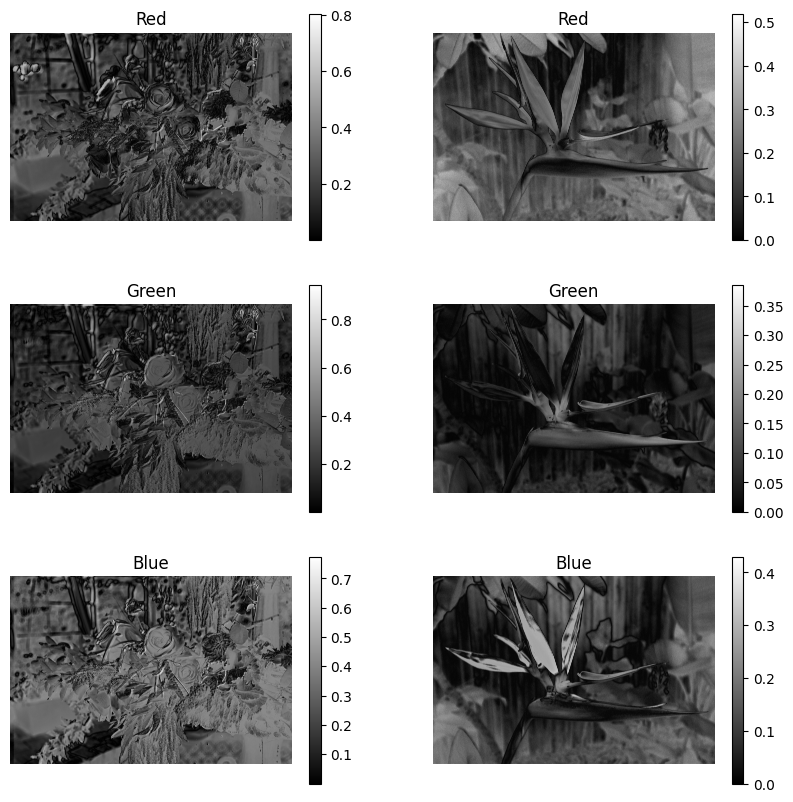

In [43]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(cubic_roses_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(cubic_roses_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(cubic_roses_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(cubic_flower_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(cubic_flower_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(cubic_flower_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()
plt.show()

Mapas para el método de Malvar.

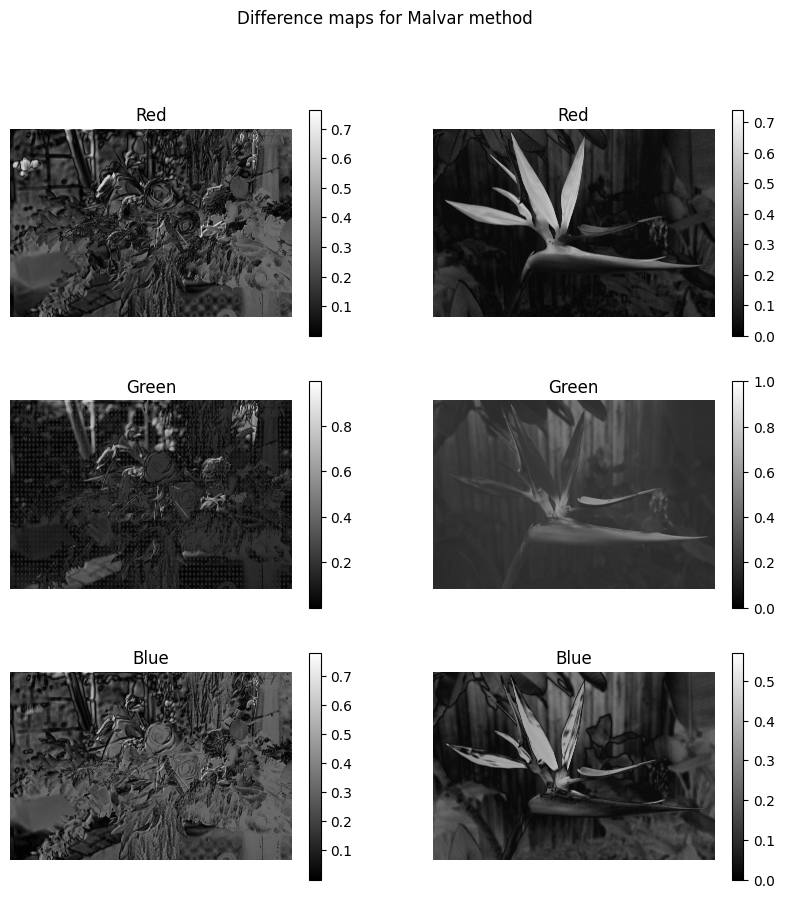

In [44]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.imshow(malvar_roses_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 3)
plt.imshow(malvar_roses_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 5)
plt.imshow(malvar_roses_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()

plt.subplot(3, 2, 2)
plt.imshow(malvar_flower_diffs[:, :, 0], cmap = 'gray')
plt.title('Red')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 4)
plt.imshow(malvar_flower_diffs[:, :, 1], cmap = 'gray')
plt.title('Green')
plt.axis('off')
plt.colorbar()
plt.subplot(3, 2, 6)
plt.imshow(malvar_flower_diffs[:, :, 2], cmap = 'gray')
plt.title('Blue')
plt.axis('off')
plt.colorbar()
plt.suptitle('Difference maps for Malvar method')
plt.show()